In [78]:
import pandas as pd
import numpy as np
import requests
import zipfile
import io
import os
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

from matplotlib import pyplot as plt
from datetime import datetime

%matplotlib inline
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150
sns.set()

In [79]:
# Define the URL for the zip file and the local filename to use
url = 'http://ergast.com/downloads/f1db_csv.zip'
filename = 'f1db_csv.zip'

# Create a data directory if it doesn't exist
if not os.path.exists('../data'):
    os.makedirs('../data')

# Download the zip file
response = requests.get(url)

# Unzip the file into the data directory
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
    zip_file.extractall('../data')

dataframes = {}

# Loop through the csv files in the data directory
for csv_file in os.listdir('../data'):
    if csv_file.endswith('.csv'):
        # Read the csv file into a dataframe 
        df_name = csv_file.replace('.csv', '')
        dataframes[df_name] = pd.read_csv(f'../data/{csv_file}')

## Question 1
### Does experience (years in Formula 1) correlate to the frequency of accidents (caused by driver)?

In [80]:
dataframes.keys()

dict_keys(['circuits', 'constructors', 'constructor_results', 'constructor_standings', 'drivers', 'driver_standings', 'lap_times', 'pit_stops', 'qualifying', 'races', 'results', 'seasons', 'sprint_results', 'status'])

In [81]:
drivers = pd.DataFrame(dataframes['drivers'])
drivers.head()

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [82]:
driver_standings = pd.DataFrame(dataframes['driver_standings'])
driver_standings.head()

,driverStandingsId,raceId,driverId,points,position,positionText,wins
0,1,18,1,10.0,1,1,1
1,2,18,2,8.0,2,2,0
2,3,18,3,6.0,3,3,0
3,4,18,4,5.0,4,4,0
4,5,18,5,4.0,5,5,0


In [83]:
results = pd.DataFrame(dataframes['results'])
results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


In [84]:
races = pd.DataFrame(dataframes['races'])
races['date']= pd.to_datetime(races['date'])
races.head()

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


### Data preparation

Define a function that calculates the number of races a certain driver had up to that point in time

In [85]:
def get_races_in_f1(row_data:pd.Series):
    try:
        raceId = row_data['raceId']
    except:
        raceId = 1120
    driverId = row_data['driverId']
    date_of_race = races[races['raceId'] == raceId]
    date_of_race = date_of_race['date'].values[0]
    races_participated = results[results['driverId'] == driverId]
    races_at_date = races[races['raceId'].isin(races_participated['raceId'].values)]
    races_at_date = races_at_date[races_at_date['date'] <= date_of_race]
    count = races_at_date.shape[0]
    return count

Define the statusIds that correspond to driver caused accidents

3: Accident, 4: Collision, 20: Spun off, 104: Fatal accident, 130: Collision damage, 137: Damage

In [86]:
crash_status = [3, 4, 20, 104, 130, 137]

Define a function that returns a list of driverIds who had more than a certain threshold of races in their career.

In [87]:
def min_races_in_career(minRaces:int):
    races_in_career = pd.DataFrame()
    races_in_career['driverId'] = drivers['driverId']
    races_in_career['numberRaces'] = races_in_career.apply(get_races_in_f1, axis=1)
    races_in_career = races_in_career[races_in_career['numberRaces'] >= minRaces]
    return races_in_career['driverId'].values

Define a new Dataframe that only includes races that happened since 1975 because since then the overall ruleset and structure of the championship has remained similar and the races are better comparable.

In [88]:
races_after_1975 = races[races['year'] >= 1975]

Create a Dataframe that contains all accidents that had one of the defined statuses in crash_status and happened after 1975. Now also only include the accidents whith drivers that drove at least 40 races (2 seasons/years) in their career. This is done to remove drivers who had basically no career and only drove some races for fun or simply were not good enough.

In [89]:
accidents = results[results['statusId'].isin(crash_status)]
accidents = accidents[accidents['raceId'].isin(races_after_1975['raceId'].values)]
accidents = accidents[accidents['driverId'].isin(min_races_in_career(40))]

accidents.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
8,9,18,9,2,4,2,\N,R,9,0.0,47,\N,\N,15,9,1:28.753,215.100,4
9,10,18,10,7,12,18,\N,R,10,0.0,43,\N,\N,23,13,1:29.558,213.166,3
13,14,18,14,9,9,8,\N,R,14,0.0,25,\N,\N,21,11,1:29.502,213.300,4
16,17,18,17,9,10,14,\N,R,17,0.0,0,\N,\N,\N,\N,\N,\N,4
17,18,18,18,11,16,12,\N,R,18,0.0,0,\N,\N,\N,\N,\N,\N,4


Define two functions, to first get the date of a race based on a raceId. The second function calculates the accident rate of a driver at a certain date. The accident rate is defined as the number of accidents up to that point divided by the number of total races up to that date.

In [90]:
def get_date_of_race(row_data:pd.Series):
    raceId = row_data['raceId']
    date_of_race = races[races['raceId'] == raceId]
    return date_of_race['date'].values[0]

def get_accident_rate(row_data:pd.Series):
    raceId = row_data['raceId']
    driverId = row_data['driverId']
    experience = row_data['experience']
    
    date_of_race = races[races['raceId'] == raceId]
    date_of_race = date_of_race['date'].values[0]
    acciddents_participated = accidents[accidents['driverId'] == driverId]

    accidents_at_date = acciddents_participated[acciddents_participated['date'] <= date_of_race]

    count = accidents_at_date.shape[0]
    accident_ratio = count / experience
    return accident_ratio

Using the functions we first append a column to the accidents Dataframe which contains the date of the accident. Then we create a new Dataframe to hold only the data we need to answer the question (driverId, raceId, statusId). Then we append two new columns to this frame. The first one is experience and it depicts the amount of races the driver had participated in at the point of the accident. The next one is the accident rate and it shows the ratio between races with accident and total amount of races of that driver at the time of the accident.

In [91]:
accidents['date'] = accidents.apply(func=get_date_of_race, axis=1)

accidents_experience = pd.DataFrame()

accidents_experience['driverId'] = accidents['driverId']
accidents_experience['raceId'] = accidents['raceId']
accidents_experience['statusId'] = accidents['statusId']
accidents_experience['experience'] = accidents_experience.apply(func=get_races_in_f1, axis=1)
accidents_experience['avg_accident_per_race'] = accidents_experience.apply(func=get_accident_rate, axis=1)

accidents_experience = accidents_experience.reset_index(drop=True)

accidents_experience.head()

,driverId,raceId,statusId,experience,avg_accident_per_race
0,9,18,4,23,0.086957
1,10,18,3,5,0.200000
2,14,18,4,230,0.121739
3,17,18,4,106,0.141509
4,18,18,4,138,0.094203


### Plotting

First we will plot the experience against the accident rate to understand the data better and maybe visually identify if there could be a correlation.

<Figure size 2400x1200 with 0 Axes>

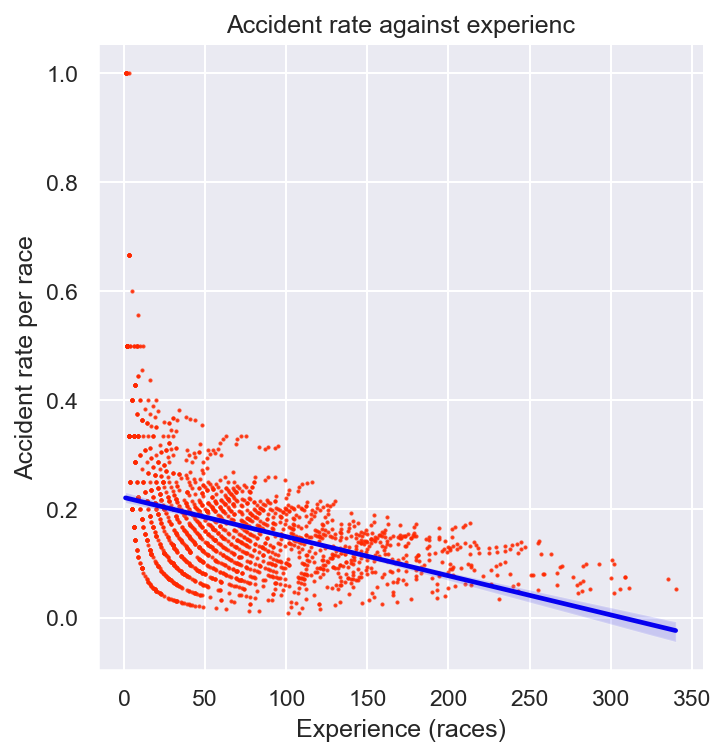

In [92]:
plt.figure(figsize=(16, 8))
sns.lmplot(data=accidents_experience, x='experience', y='avg_accident_per_race', fit_reg=True, scatter_kws={'s':1, 'color':'#FF2800'}, line_kws={'color':'#0600EF'})
plt.title('Accident rate against experienc')
plt.ylabel('Accident rate per race')
plt.xlabel('Experience (races)')
plt.show()

As we can see there seems to be at least a small negative correlation. To find out more we calculate the correlation coefficient.

In [93]:
print(accidents_experience['avg_accident_per_race'].corr(accidents_experience['experience']))

-0.3815753848768522


The coefficient tells us that there is indeed a small negative correlation. However as it can be seen in the plot there seem to be way more data points for low experience than for high experience. This is because there are a lot of drivers which had a short career and never reached the point where they got really experienced. To explore this theory further we will now only look at the 10 drivers with the longest career since 1975. We will create a new Dataframe only containing the accidents of those drivers.

In [94]:
accidents_10_drivers = accidents_experience[accidents_experience['driverId'].isin(min_races_in_career(250))]
accidents_10_drivers.head()

,driverId,raceId,statusId,experience,avg_accident_per_race
4,18,18,4,138,0.094203
5,20,18,4,9,0.222222
7,13,19,20,90,0.111111
9,18,20,4,140,0.100000
10,22,21,4,257,0.116732


Now we will plot the data again and calculate the correlation coefficient once more.

<Figure size 2400x1200 with 0 Axes>

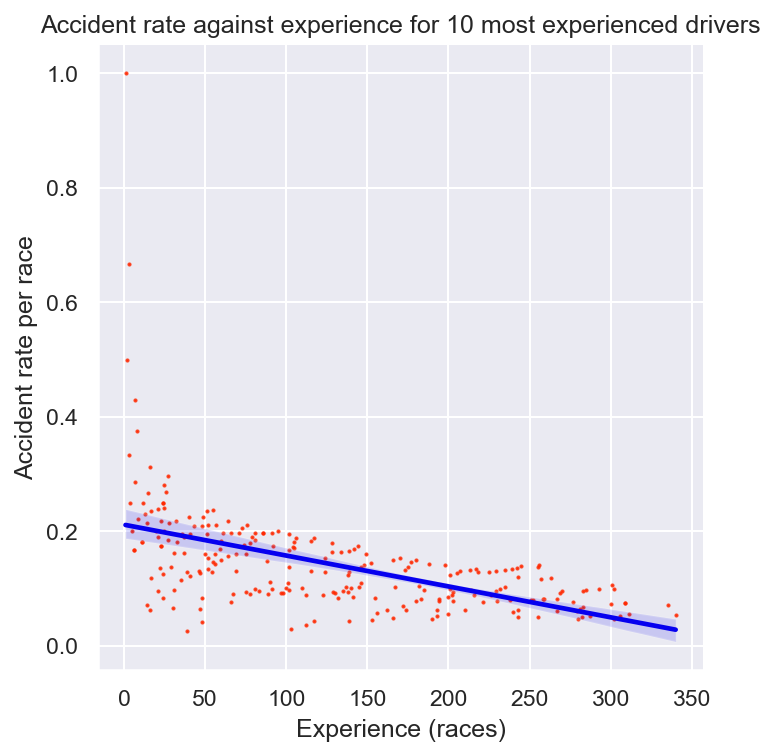

-0.5223298371063038


In [95]:
plt.figure(figsize=(16, 8))
sns.lmplot(data=accidents_10_drivers, x='experience', y='avg_accident_per_race', fit_reg=True, scatter_kws={'s':1, 'color':'#FF2800'}, line_kws={'color':'#0600EF'})
plt.title('Accident rate against experience for 10 most experienced drivers')
plt.ylabel('Accident rate per race')
plt.xlabel('Experience (races)')
plt.show()

print(accidents_10_drivers['avg_accident_per_race'].corr(accidents_10_drivers['experience']))

Now the correlation becomes much more clear and this is also depicted by the coefficient. This shows that the more experience a driver gains (participation in races), the lower on average their accident rate will be.

Now we will take a look at the type of accident. When the status of an accident is 'Collision damage' or id 130 the accident is considered minor since there was less damage than in the other types mentioned before.

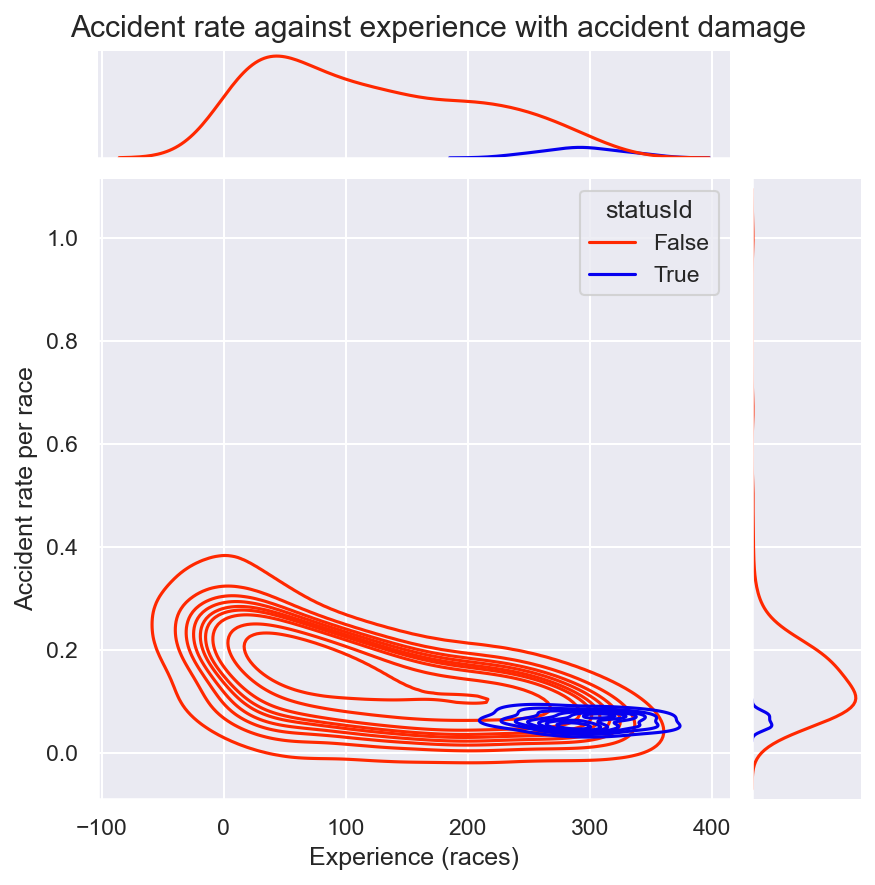

In [96]:
mask_not_severe = accidents_10_drivers['statusId'] == 130

sns.jointplot(data=accidents_10_drivers, x='experience', y='avg_accident_per_race', hue=mask_not_severe, palette=sns.color_palette(["#FF2800", "#0600EF"]), kind='kde')
plt.suptitle(t='Accident rate against experience with accident damage')
plt.subplots_adjust(top=0.94)
plt.ylabel('Accident rate per race')
plt.xlabel('Experience (races)')
plt.show()

The above plot shows that the minor accidents tend to be more towards the higher end of experience. This means that when a driver is more experienced they have more accidents which are considered minor. This is probably due to the fact that the driver can control their car better and knows the limits and risks better than an inexperienced driver.

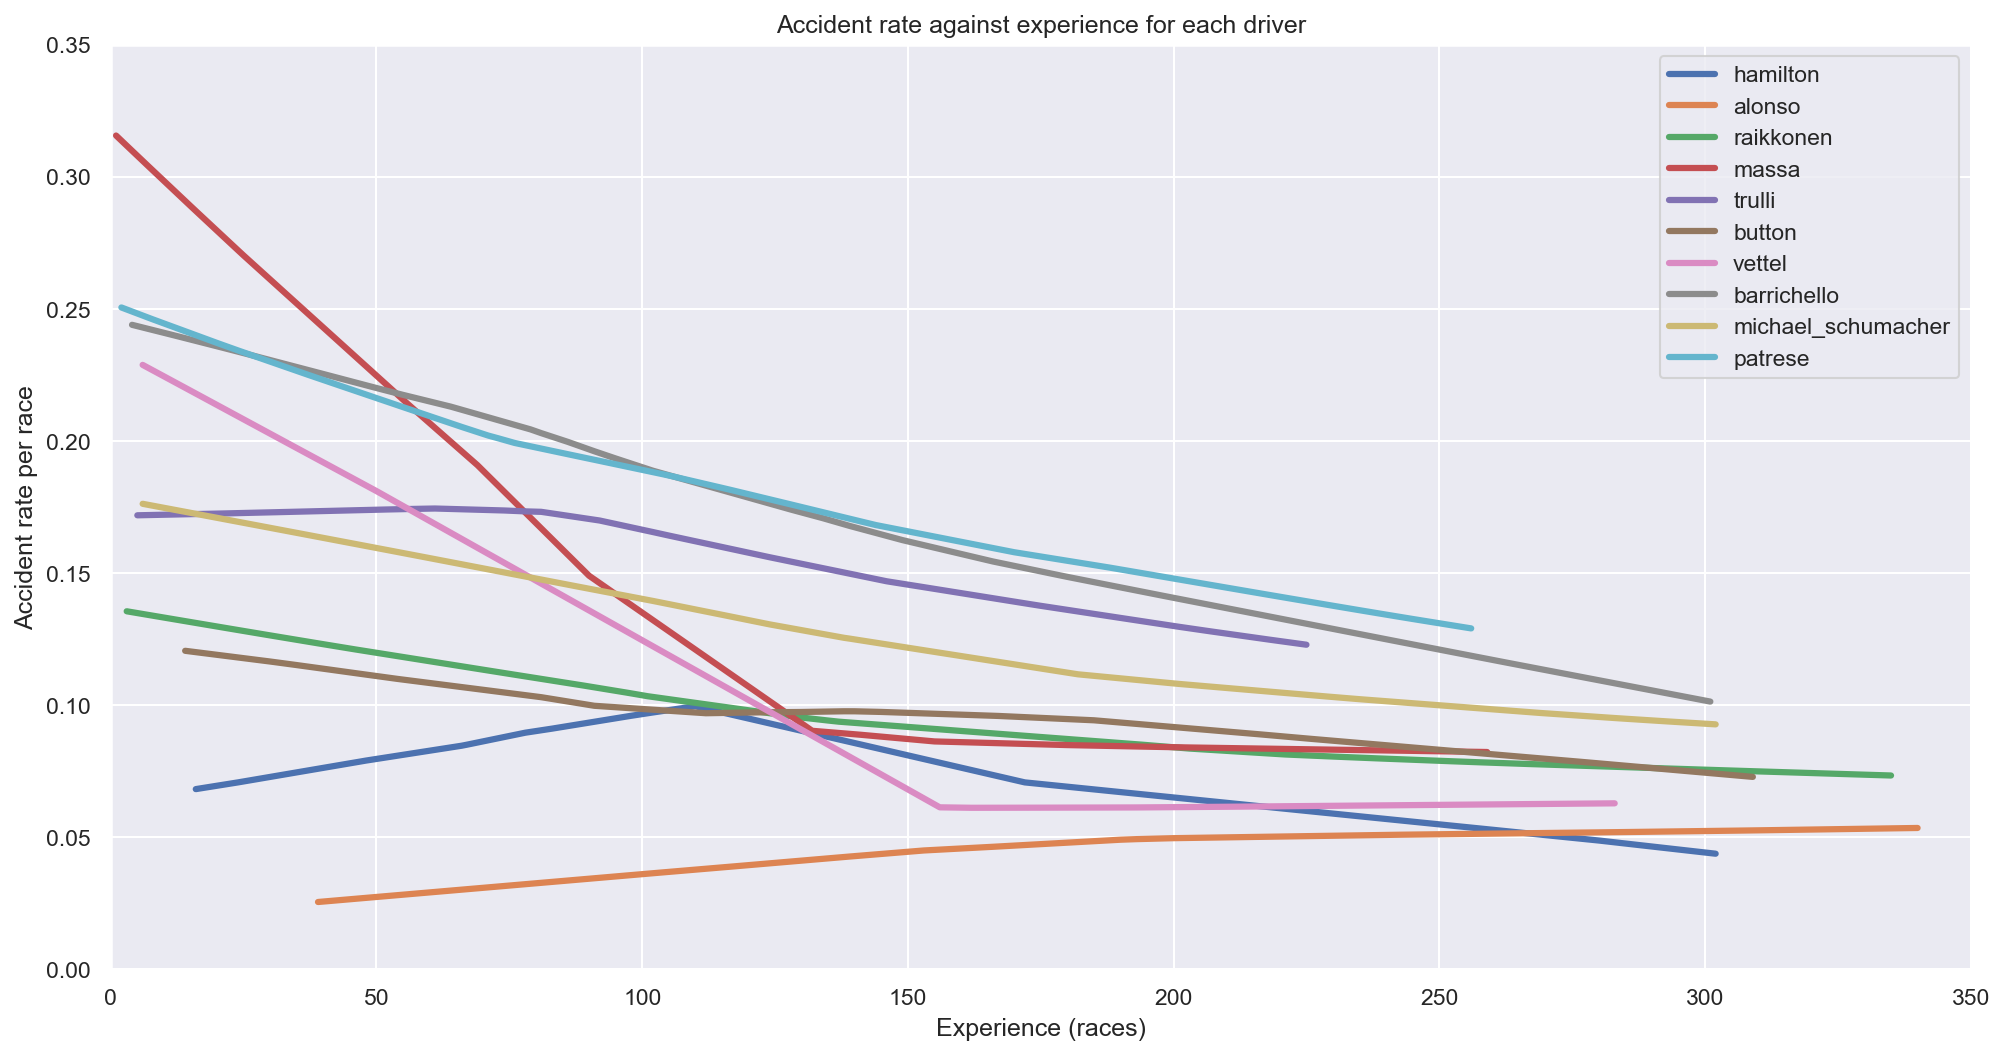

In [99]:
accident_drivers = accidents_10_drivers.groupby('driverId').agg(num_crashes=('experience', 'nunique')).index.to_list()

for driver in accident_drivers:
    y = accidents_10_drivers.loc[(accidents_10_drivers['driverId'] == driver), 'avg_accident_per_race']
    x = accidents_10_drivers.loc[(accidents_10_drivers['driverId'] == driver), 'experience']
    ysmooth = lowess(y, x, return_sorted=False)
    sns.lineplot(x=x, y=ysmooth, label=drivers.loc[drivers['driverId'] == driver, 'driverRef'].values[0], linewidth=3)

plt.ylabel('Accident rate per race')
plt.xlabel('Experience (races)')
plt.title('Accident rate against experience for each driver')
plt.ylim((0.0, 0.35))
plt.xlim((0, 350))
plt.show()

This last plot shows the individual accident rates of the 10 most experienced drivers throughout their careers. As can be seen most of them go down meaning less accidents the more experience they have. However there are some outliers like Alonso whos accident rate increased over the span of his career. It has to be said that his rate overall even at its peak is still mostly lower than that of any other driver, so he just seems to be very consistent and safe in his driving.